In [1]:
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots
using AIDA

┌ Info: Precompiling AIDA [02ab3c64-7f6e-4624-92b1-4056b28faae1]
└ @ Base loading.jl:1317


In [4]:
# clean speech
cl, fs = wavread("../sound/NOIZEUS/clean/sp01.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn

22529×1 Matrix{Float64}:
 -0.00046763752580127787
 -0.0006094744065808604
 -7.097915104639738e-5
 -0.01461308373610466
  0.00615969880821781
  0.00525973955609931
 -0.00821867706106581
 -0.016525929559686355
 -0.006795829992850632
 -0.0015320208207234556
  0.02099203921442713
 -0.002339696440186513
  0.017648556011353976
  ⋮
 -0.004471954830247699
  0.0063622741948341855
  0.0047384810207933975
  0.014716720072550437
  0.010537505662980298
 -0.00107952555591571
  0.008633440662738879
 -0.00017373833084936532
  0.0008542491890155472
  0.0124019744769053
 -0.012644681140644973
 -0.0203042407021123

In [5]:
cl_seg = get_frames(cl, fs)
ns_seg = get_frames(ns, fs)
totseg = size(ns_seg, 1)

376

In [7]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [15]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(ns_seg[segnum, :], ar_order)
    γ, τ, θ, x, fe = lar_inference_ex(outputs, ar_order, vmp_iter, priors=Dict(:aτ => 1e-4, :bτ => 1e-4, :aγ => 1e-4, :bγ => 1e-4))
    # mθ, vθ = mean(θ), cov(θ)
    # mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter, priors=Dict(aτ => 1e-4, :bτ => 1e-4))
    # mx, vx = mean(x), cov(x)
    # mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:37


In [16]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))];

In [17]:
rsegs = findall(isequal(1), vad)
nsegs = findall(isequal(0), vad);

In [18]:
rseg = rand(rsegs)
nseg = rand(nsegs)
println("$(rseg), $(nseg)")

292, 201


In [19]:
inv(var(sum([ns_seg[nseg, :] for nseg in nsegs])))

17.629440898335595

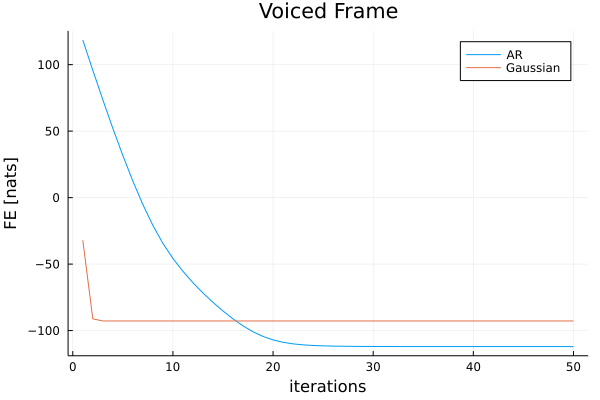

In [20]:
plot(fe_ar[rseg, :], label="AR")
plot!(fe_gaussian[rseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Voiced Frame")

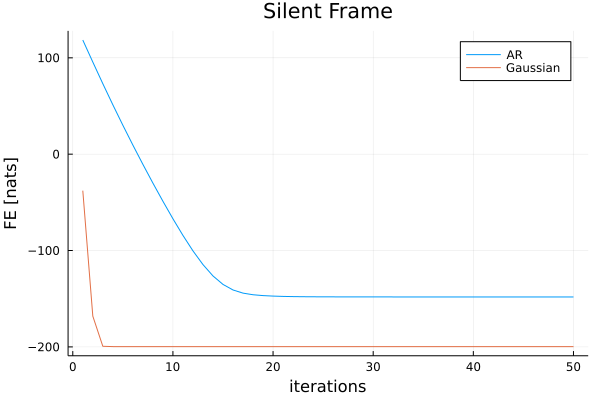

In [21]:
plot(fe_ar[nseg, :], label="AR")
plot!(fe_gaussian[nseg, :], label="Gaussian", ylabel="FE [nats]", xlabel="iterations", title="Silent Frame")

In [22]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

-92.77501482392503, -112.06461150915584


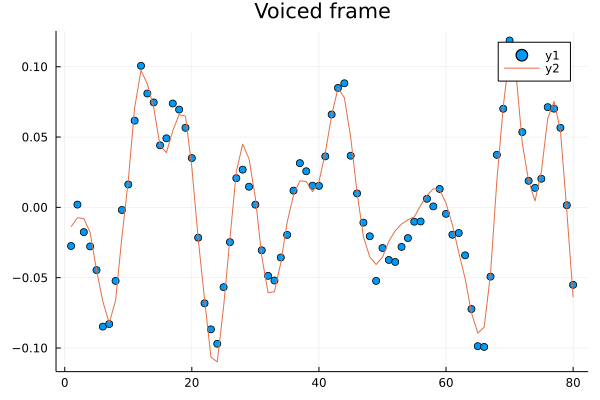

In [23]:
scatter(ns_seg[rseg, :])
plot!(cl_seg[rseg, :], title="Voiced frame")

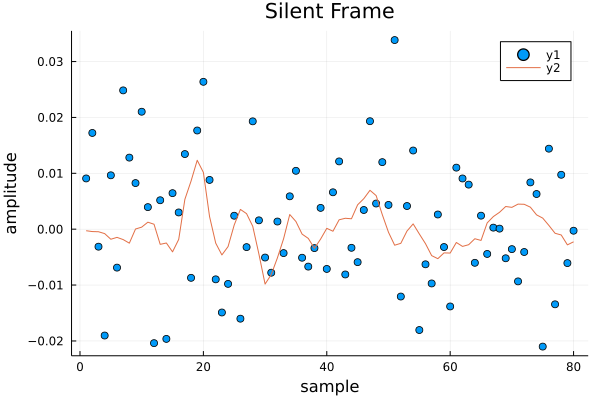

In [24]:
scatter(ns_seg[nseg, :])
plot!(cl_seg[nseg, :], ylabel="amplitude", xlabel="sample", title="Silent Frame")

In [211]:
include("helpers/aida_segmentation.jl")
check = get_signal(hcat([ns_seg[nseg, :] for nseg in nsegs]...)', 8000)
using WAV
wavwrite(check, fs, "/Users/apodusenko/Desktop/check.wav")